# Math 4383 Project
### Zachary Koenig, Colin Crippen

In [78]:
!pip install matplotlib

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import csv

In [80]:
# --- Load the 8x8 digits dataset ---
digits = load_digits()

# The dataset contains 8x8 images and their corresponding digit labels.
# X contains image data and y contains the target labels.
IMAGES = digits.images      # Shape: (num_images, 8, 8)
LABELS = digits.target      # Shape: (num_images,)

# --- Data Preprocessing ---

# 1. Flatten the images:
#    Convert each 8x8 image into a 1D array of 64 pixels.
num_images = IMAGES.shape[0]
flattened_images = IMAGES.reshape(num_images, -1)   # Now shape is (num_images, 64)

# 2. Normalize the inputs:
#    The pixel values in the digits dataset are in the range 0-16.
#    Dividing by 16 scales them to the range [0, 1].
normalized_flat_images = flattened_images / 16.0

# 3. One-Hot Encode the Labels:
#    There are 10 classes (digits 0-9), so create one-hot encoded vectors.
num_classes = 10
labels_onehot = np.eye(num_classes)[LABELS]

# --- Split into Training and Verification (Validation) Sets ---
# For example, reserve 20% of the data for validation
image_train_set, image_validatoin_set, labels_train_set, labels_validation_set = train_test_split(
    normalized_flat_images, labels_onehot, test_size=0.2, random_state=4651
)

# Verify the shapes
print("Training set shape:", image_train_set.shape, labels_train_set.shape)  # Should show ~80% of the samples
print("Validation set shape:", image_validatoin_set.shape, labels_validation_set.shape)      # Should show ~20% of the samples
print("One-hot encoded y shape:", labels_onehot.shape)    # Expected: (num_samples, 10)

Training set shape: (1437, 64) (1437, 10)
Validation set shape: (360, 64) (360, 10)
One-hot encoded y shape: (1797, 10)


To enable nonlinear function representation, we'll use the "Sigmoid" activation function

### Sigmoid Function:

$\sigma(x) = \Large\frac{1}{1 + e^{-x}}$

(where $x$ in this program is the weighted sum of the inputs plus the bias from the layer just processed)

- Squashes any real input into the interval $(0,1)$.
- Smooth and differentiable everywhere, which makes gradient‑based learning possible.

### Sigmoid Derivative:
$\sigma'(x) = \sigma(x)\,\bigl(1 - \sigma(x)\bigr)$

(where $x$ in this program is the weighted sum of the inputs plus the bias at the layer from the forward pass)

- Simple closed‑form in terms of $σ(x).$
- Used during backprop to propagate error gradients through the nonlinearity.

### Softmax Function
**Mathematical form:**  

$
\mathrm{softmax}(\mathbf{z})_i
= \Large\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$

(where)

### Safe Softmax Function
**Mathematical form (for a vector $\mathbf{z}\in\mathbb{R}^K$):**

$
\mathrm{softmax}(\mathbf{z})_i
= \Large\frac{e^{z_i - \max_j (z_j)}}
       {\sum_{k=1}^K e^{z_k - \max_j (z_j)}}
$


##### Risks of Standard Softmax:
- **Numerical overflow**  
   - If any $z_i$ is large $(e.g.\ \ z_i > 700)$, then $e^{z_i}$ can overflow to $\infty$.  
   - Subtracting $max_j (z_j)$ ensures the largest exponent is $e^0 = 1$, keeping all values in a safe range.

- **Numerical underflow**  
   - If all $z_i$ are very negative, $e^{z_i}$ can underflow to $0$.  
   - Centering by $max_j (z_j)$ prevents all exponentials from collapsing to $0$, preserving meaningful probability ratios.

##### Benefit of Safe Softmax
- Converts raw scores into a probability distribution over $K$ classes (they sum to 1).
- Subtracting $max_j (z_j)​$  ensures numerical stability.

In [81]:
# --- Activation functions and their derivatives ---

def sigmoid(x):
    """Compute the sigmoid activation."""
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """Compute the derivative of the sigmoid function."""
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)

def softmax(x):
    """Compute the softmax activation for each row of x."""
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exps / np.sum(exps, axis=1, keepdims=True)

In [82]:
# --- Hyperparameters ---
input_layer_size = 8 * 8   # 64 inputs, one per pixel
hidden_layer_size = 64       # You can adjust this
output_layer_size = 10       # 10 classes for digits 0-9

learning_rate = 0.1
epochs = 10_000

# --- Initialize Weights and Biases ---
np.random.seed()  # For reproducibility
input_layer_weights = np.random.randn(input_layer_size, hidden_layer_size) * 0.01
input_layer_biases = np.zeros((1, hidden_layer_size))
hidden_layer_weights = np.random.randn(hidden_layer_size, output_layer_size) * 0.01
hidden_layer_biases = np.zeros((1, output_layer_size))

### Hidden‐Layer Forward Pass
**Equations:**

$
Z^{[1]} = X\,W^{[1]} + b^{[1]},\quad
A^{[1]} = \sigma\bigl(Z^{[1]}\bigr)
$

### Output‐Layer Forward Pass (Training)
**Equations:**  

$
Z^{[2]} = A^{[1]}\,W^{[2]} + b^{[2]},\quad
A^{[2]} = \sigma\bigl(Z^{[2]}\bigr)
$


In [ ]:
    
# Accepts an array of any number of images (0<)

# returns:
#       - linear combination of weights and pixel values, plus the bias for each image for the input to hidden layer (as an array)
#       - the "activation" of each neuron from the input layer (if "x" neurons, then x*(number of images) activation values)
#       - linear combination of weights and pixel values, plus the bias for each image for the hidden layer to the output layer (as an array)
#       - the "activation" of each neuron from the hidden layer (if "x" neurons, then x*10 (the number of categories) activation values)

def forward_pass(flattened_image_set):
    Z1 = np.dot(flattened_image_set, input_layer_weights) + input_layer_biases          # Input to hidden layer
    input_layer_neuron_values = sigmoid(Z1)                                             # Hidden layer activation
    Z2 = np.dot(input_layer_neuron_values, hidden_layer_weights) + hidden_layer_biases  # Hidden to output layer
    hidden_layer_neuron_values = sigmoid(Z2)                                            # Output activation
    return Z1, input_layer_neuron_values, Z2, hidden_layer_neuron_values

# Cross‑Entropy Loss

**Mathematical form:**  
$
\mathcal{L} = -\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K y_{i,k}\,\log\bigl(A^{[2]}_{i,k} + \epsilon\bigr)
$

#### Why add a small constant $\epsilon$ for numerical stability

1. **Avoid $\log(0)\to -\infty$**  
   - If \(A^{[2]}_{i,k}=0\), then \(\log(0)\) is undefined.  
   - Adding \(\epsilon\) ensures \(\log\bigl(A^{[2]}_{i,k} + \epsilon\bigr)\) remains finite.

2. **Prevent NaNs and infinities in loss computation**  
   - Keeps the computed loss a real number even when predictions are exactly zero.

3. **Stable backpropagation**  
   - Ensures gradients remain well‑defined, avoiding infinite or undefined gradient values.

In [84]:
def calculate_loss(A2):
    # Compute Cross-Entropy Loss (adding a small constant for numerical stability)
    return -np.mean(np.sum(labels_train_set * np.log(A2 + 1e-8), axis=1))

### Backpropagation Gradients
**Output layer gradients:**  

$
dZ^{[2]} = A^{[2]} - Y,\quad
dW^{[2]} = \frac{(A^{[1]})^\top\,dZ^{[2]}}{m},\quad
db^{[2]} = \frac{1}{m}\sum_i dZ^{[2]}_{i,\ast}
$

**Hidden layer gradients:**  

$
dA^{[1]} = dZ^{[2]}\,(W^{[2]})^\top,\quad
dZ^{[1]} = dA^{[1]}\,\circ\,\sigma'\bigl(Z^{[1]}\bigr)
$

$
dW^{[1]} = \frac{X^\top\,dZ^{[1]}}{m},\quad
db^{[1]} = \frac{1}{m}\sum_i dZ^{[1]}_{i,\ast}
$

### Parameter Updates
**Gradient descent step:**  

$
W^{[\ell]} \leftarrow W^{[\ell]} - \alpha\,dW^{[\ell]},\quad
b^{[\ell]} \leftarrow b^{[\ell]} - \alpha\,db^{[\ell]}
\quad(\ell=1,2)
$

In [85]:
def accuracy_check(epoch, loss):
    # Training Accuracy (using the training forward pass already computed)
    train_preds = np.argmax(hidden_layer_neuron_values, axis=1)
    true_train_labels = np.argmax(labels_train_set, axis=1)
    train_accuracy = np.mean(train_preds == true_train_labels)
    
    # Validation: perform a forward pass over the validation set.
    Z1_val = np.dot(image_validatoin_set, input_layer_weights) + input_layer_biases
    A1_val = sigmoid(Z1_val)
    Z2_val = np.dot(A1_val, hidden_layer_weights) + hidden_layer_biases
    A2_val = softmax(Z2_val)
    
    val_preds = np.argmax(A2_val, axis=1)
    true_val_labels = np.argmax(labels_validation_set, axis=1)
    val_accuracy = np.mean(val_preds == true_val_labels)
    
    print(f"Epoch {epoch}: loss = {loss:.4f}, train acc = {train_accuracy:.4f}, val acc = {val_accuracy:.4f}")
    return (epoch, loss, train_accuracy, val_accuracy)

In [ ]:
# --- Lists to Save Progress Data ---
progress_data = []  # Each element: (epoch, loss, training set accuracy, validation set accuracy)

# --- Training Loop ---
num_train_samples = image_train_set.shape[0]  # Use real number of training samples
for epoch in range(epochs):

    Z1, input_layer_neuron_values, Z2, hidden_layer_neuron_values = forward_pass(image_train_set)
    
    loss = calculate_loss(hidden_layer_neuron_values)
    
       # Backward pass:
    # For softmax and cross-entropy, the gradient simplifies:
    dZ2 = hidden_layer_neuron_values - labels_train_set
    dW2 = np.dot(input_layer_neuron_values.T, dZ2) / image_train_set.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / image_train_set.shape[0]
    
    dA1 = np.dot(dZ2, hidden_layer_weights.T)
    dZ1 = dA1 * sigmoid_deriv(Z1)
    dW1 = np.dot(image_train_set.T, dZ1) / image_train_set.shape[0]
    db1 = np.sum(dZ1, axis=0, keepdims=True) / image_train_set.shape[0]
    
    # Update the weights and biases using gradient descent:
    hidden_layer_weights -= learning_rate * dW2
    hidden_layer_biases -= learning_rate * db2
    input_layer_weights -= learning_rate * dW1
    input_layer_biases -= learning_rate * db1

    # During training, sample 100 times to compute and record training accuracy and loss
    if epoch % max(1, epochs // 100) == 0:
        progress_data.append(accuracy_check(epoch, loss))
        
# Save progress data to CSV
csv_filename = "training_progress.csv"
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["epoch", "loss", "train_accuracy", "val_accuracy"])
    for record in progress_data:
        writer.writerow(record)

# Save the trained weights and biases to disk
np.save('W1.npy', input_layer_weights)
np.save('b1.npy', input_layer_biases)
np.save('W2.npy', hidden_layer_weights)
np.save('b2.npy', hidden_layer_biases)

64.0
10.0
Epoch 0: loss = 0.0864, train acc = 0.9896, val acc = 0.9694
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0
64.0
10.0

KeyboardInterrupt: 

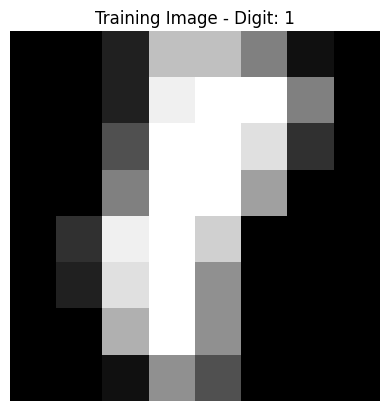

Original shape of image: (8, 8)
Flattened shape of image: (1, 64)
[[2.15434620e-07 8.78117961e-01 1.05538560e-04 1.14113064e-06
  4.51796373e-02 6.98095878e-07 9.06951344e-07 1.72980156e-02
  1.26407809e-01 1.12228163e-03]]
Predicted digit: 1
With 87.81 percent confidence


In [87]:
# --- Display and Test One Image ---
# Select a random image from the validation set
idx = np.random.randint(0, image_validatoin_set[0].shape)
# Since the image validation set contains flattened images, reshape it back to 8x8 for display.
img = image_validatoin_set[idx].reshape(8, 8)
label = np.argmax(labels_validation_set[idx])

# Save the image array to a file. Note that the file name comes first.
np.save("test.npy", img)

plt.imshow(img, cmap='gray')
plt.title(f"Training Image - Digit: {label}")
plt.axis('off')
plt.show()

input_layer_weights = np.load('W1.npy')
input_layer_biases = np.load('b1.npy')
hidden_layer_weights = np.load('W2.npy')
hidden_layer_biases = np.load('b2.npy')

# Load the test image. This image is expected to be an 8x8 array.
test_image = np.load('test.npy')
print("Original shape of image:", test_image.shape)  # Should output: (8, 8)

# Flatten the image so that it has shape (1, 64)
flat_test_image = test_image.reshape(1, -1)
print("Flattened shape of image:", flat_test_image.shape)  # Should output: (1, 64)

# Perform the forward pass with the currently saved weights and biases
Z1, input_layer_neuron_values, Z2, hidden_layer_neuron_values = forward_pass(flat_test_image)
probability = np.max(hidden_layer_neuron_values)
prediction = np.argmax(hidden_layer_neuron_values)
print(hidden_layer_neuron_values)
print("Predicted digit:", prediction)
print( "With", round(probability * 100, 2), "percent confidence")

In [88]:
# --- Perform Predictions on the Test Set Using the Loaded Weights ---
# Forward pass:
# 1. Compute activations for the hidden layer.
Z1 = np.dot(image_validatoin_set, input_layer_weights) + input_layer_biases   # Linear combination for the hidden layer.
A1 = sigmoid(Z1)              # Apply sigmoid activation.

# 2. Compute activations for the output layer.
Z2 = np.dot(A1, hidden_layer_weights) + hidden_layer_biases       # Linear combination for the output layer.
A2 = sigmoid(Z2)              # Output activations.

# The predicted class for each sample is the one with the highest activation.
predictions = np.argmax(A2, axis=1)
true_labels = np.argmax(labels_validation_set, axis=1)

# Calculate the accuracy of the model on the test set.
accuracy = np.mean(predictions == true_labels)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))

Test set accuracy: 96.94%


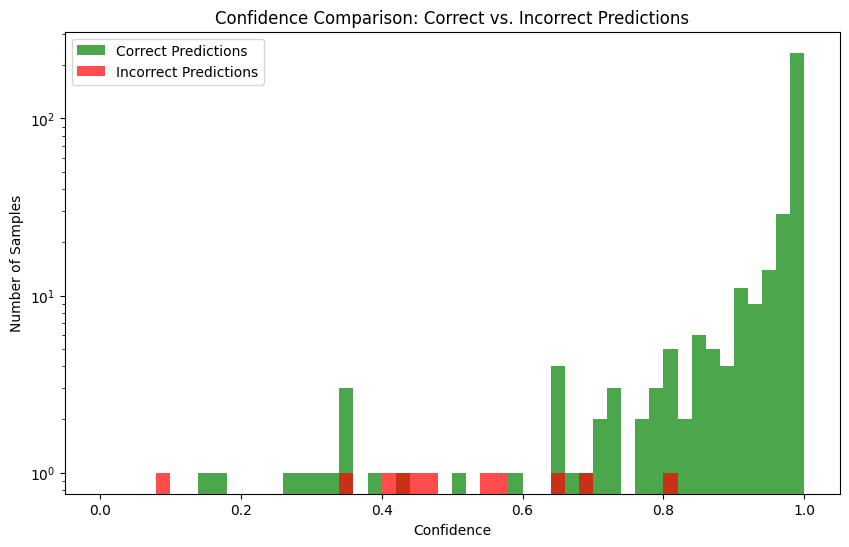

In [89]:
def plot_confidence_comparison(probabilities, true_labels, bins=20):
    """
    Plots histograms comparing the confidence scores for correctly vs.
    incorrectly classified samples.
    
    Parameters:
        probabilities (np.ndarray): A 2D array of shape (n_samples, n_classes) 
            containing the predicted probabilities (e.g., outputs of softmax).
        true_labels (np.ndarray): A 1D array of true labels (integers) of shape (n_samples,).
            If your labels are in one-hot format, convert them using np.argmax.
        bins (int): Number of bins for the histogram.
    """
    # Compute predicted labels (choose the class with the highest probability).
    predictions = np.argmax(probabilities, axis=1)
    
    # Compute the confidence for each prediction as the maximum probability.
    confidences = np.max(probabilities, axis=1)

    # Create consistent bin edges from 0 to 1.
    bin_edges = np.linspace(0, 1, bins + 1)
    
    # Separate confidence scores based on whether the prediction was correct.
    correct_confidences = confidences[predictions == true_labels]
    incorrect_confidences = confidences[predictions != true_labels]
    
    # Plot histograms for the two groups.
    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=bin_edges, alpha=0.7, label='Correct Predictions', color='green')
    plt.hist(incorrect_confidences, bins=bin_edges, alpha=0.7, label='Incorrect Predictions', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Number of Samples')
    plt.yscale("log")
    plt.title('Confidence Comparison: Correct vs. Incorrect Predictions')
    plt.legend()
    plt.show()

plot_confidence_comparison(A2, true_labels, 50)

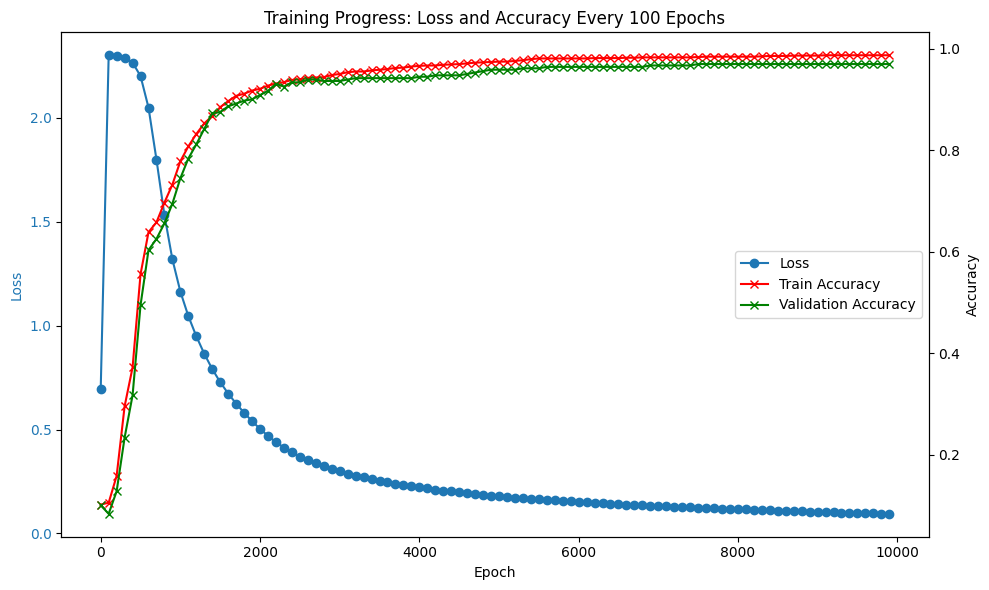

In [90]:
# --- Graphing Function to Plot the Training Progress ---
def plot_training_progress(csv_filepath):
    """
    Reads the CSV with training progress data (epoch, loss, training accuracy, validation accuracy)
    and plots the loss and accuracy curves. Loss is plotted on the left y-axis, while accuracy (both training
    and validation) is plotted on the right y-axis with training accuracy in red and validation accuracy in green.
    """
    epochs_list = []
    loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    with open(csv_filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            epochs_list.append(float(row["epoch"]))
            loss_list.append(float(row["loss"]))
            train_acc_list.append(float(row["train_accuracy"]))
            val_acc_list.append(float(row["val_accuracy"]))
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Loss on the left y-axis
    color_loss = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss)
    ax1.plot(epochs_list, loss_list, marker='o', color=color_loss, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)
    
    # Create a second y-axis for the accuracies
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='black')
    ax2.plot(epochs_list, train_acc_list, marker='x', color='red', label='Train Accuracy')
    ax2.plot(epochs_list, val_acc_list, marker='x', color='green', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Combine legends from both axes and display
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    
    plt.title('Training Progress: Loss and Accuracy Every 100 Epochs')
    plt.tight_layout()
    plt.show()

# Call the graphing function to display the plot.
plot_training_progress(csv_filename)